In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import jax
import jax.numpy as jnp
import visualization
from utils import results, experiments,settings, equioutput, evaluation
import global_settings

from numpyro import distributions
import matplotlib.pyplot as plt

In [2]:
result = results.ResultSample.load_from_file(os.path.join(global_settings.PATH_PAPER_RESULTS, "{}.tar.gz".format(
    "d172bb3351d21af3d07c84b34f188223"
)))


experiment = experiments.FactoryExperiment(result.experiment_type, **{"settings": result.settings})()
print(experiment._settings)

SettingsExperimentSample(output_path='/home/user/gw/data/experiments/paper/results', dataset='izmailov', dataset_normalization='standardization', hidden_layers=3, hidden_neurons=16, activation='tanh', activation_last_layer='none', num_warmup=1024, statistic='reduced', statistic_p=0.99, samples_per_chain=1, identifiable_modes=3, pool_size=32, seed=0, overwrite_chains=None)


In [4]:
def kl_divergence_old(p_values, q_values):
    assert p_values.shape == q_values.shape
    
    # normalize
    p_values /= p_values.sum()
    q_values /= q_values.sum()
    
    n = len(p_values.flatten())
    return (p_values * (jnp.log(p_values + 1e-9) - jnp.log(q_values + 1e-9))).sum()# / n

def kl_divergence(p_values, q_values):
    assert p_values.shape == q_values.shape
    
    # normalize
    p_values /= p_values.sum(1)[:, jnp.newaxis]
    q_values /= q_values.sum(1)[:, jnp.newaxis]
    
    return (p_values * (jnp.log(p_values + 1e-6) - jnp.log(q_values + 1e-6))).sum(-1)

In [5]:
# distribution stuff
resolution = 512
x = jnp.linspace(-3.0, 3.0, resolution)[:, jnp.newaxis]
y = jnp.linspace(-3.0, 3.0, 2 * resolution)[:, jnp.newaxis]

#jax.scipy.special.logsumexp
#parameters_prior_distribution = experiment._model._parameters_prior(jnp.zeros(sample.shape), jnp.ones(sample.shape))
#std = result.samples['std'].mean()

posterior_predictive_history = []
posterior_predictive = jnp.zeros((x.shape[0], y.shape[0]))
means_history = []
kl_divergences = []
kl_divergences_parameters = []

n = len(result.samples["parameters"])
for i in range(n):
    if i % 100 == 0:
        print(i)
    sample = result.samples["parameters"][i]
    std = result.samples["std"][i]
    means = experiment._model_transformation.apply_from_vector(x, sample)
    means_history.append(means)   
    likelihood_distribution = experiment._model._outputs_likelihood(means, jnp.ones_like(means) * std)
    log_likelihood = likelihood_distribution.log_prob(y.squeeze())
    likelihood = jnp.exp(log_likelihood)
    posterior_predictive += likelihood
    posterior_predictive_history.append(posterior_predictive / (i + 1))
    if i > 0:
        # posterior predictive
        tmp_posterior_predictive_before = posterior_predictive_history[-2]
        tmp_posterior_predictive_after = posterior_predictive_history[-1]
        kl_divergence_value = kl_divergence(
            tmp_posterior_predictive_after,
            tmp_posterior_predictive_before
        )
        kl_divergences.append(kl_divergence_value.mean().item())
        
        # posterior parameters - THIS REQUIRES FITTING FIRST - MAYBE KDE?
        #kl_divergences_parameters.append(kl_divergence(
        #    result.samples["parameters"][:i + 1],
        #    result.samples["parameters"][:i]
        #).item())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200


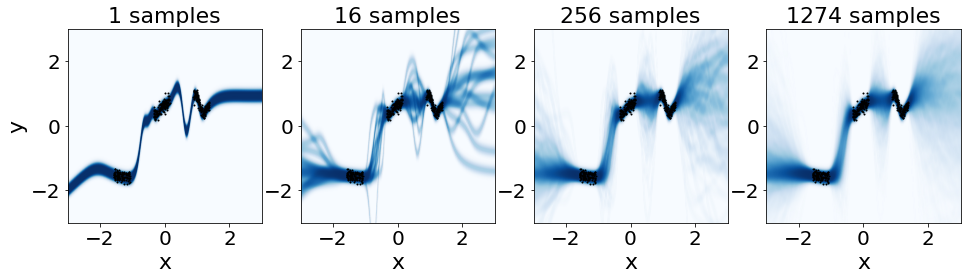

In [6]:
xx, yy = jnp.meshgrid(x.squeeze(), y.squeeze())
textsize=22
csfont = {'fontname':'Times New Roman'}

indices = [0, 15, 255, n-1]
cols = 4
rows = 1
plots = cols * rows
figure = plt.figure(figsize=(4 * cols, 4 * rows))
for row in range(rows):
    for col in range(cols):
        i = row * cols + col
        #posterior = int(((1.0 * i) / plots) * n)
        posterior = indices[i]
        ax = figure.add_subplot(rows, cols, i + 1)
        ax.set_xlim(-3.0, 3.0)
        ax.set_ylim(-3.0, 3.0)
        ax.set_title(f"{posterior + 1} samples", **csfont)
        
        if col == 0:
            ax.set_ylabel("y")
        if row == rows - 1:
            ax.set_xlabel("x")
        maximum, minimum = posterior_predictive_history[posterior].max(), posterior_predictive_history[posterior].min()
        values = 1.0 - (posterior_predictive_history[posterior] - minimum) / (maximum - minimum)
        values = posterior_predictive_history[posterior]
        ax.pcolormesh(xx, yy, 0.2**(values.T + 1e-6), cmap="Blues_r", shading="gouraud", rasterized=True)
        ax.scatter(experiment._dataset.data[:, 0], experiment._dataset.data[:, 1], c="black", s=1, rasterized=True)
        ax.yaxis.label.set_size(textsize)
        ax.xaxis.label.set_size(textsize)
        ax.tick_params(axis='both', which='major', labelsize=textsize - 2)
        ax.tick_params(axis='both', which='minor', labelsize=textsize - 2)
        ax.title.set_size(textsize)
        ax.set_aspect("equal")

#for mean in means_history:
#    ax.plot(x, mean, c="blue", alpha=0.01)

In [7]:
figure.savefig(os.path.join(global_settings.PATH_FIGURES, "posterior_predictive.pdf"), bbox_inches="tight", dpi=300, transparent=True)

In [8]:
total_kl_divergences = []
for pp in posterior_predictive_history:
    total_kl_divergences.append(kl_divergence(
        posterior_predictive_history[-1],
        pp
    ).mean())

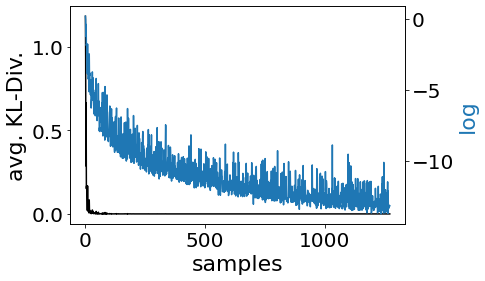

In [12]:
figure = plt.figure(figsize=(6, 4))
ax1 = figure.add_subplot(1, 1, 1)
ax1.plot(jnp.arange(n-1), jnp.array(kl_divergences)[:n], color="black")
ax1.set_xlabel("samples")
ax1.set_ylabel(r"avg. KL-Div.", color="black")
ax1.yaxis.label.set_size(textsize)
ax1.xaxis.label.set_size(textsize)
ax1.tick_params(axis='both', which='major', labelsize=textsize - 2)
ax1.tick_params(axis='both', which='minor', labelsize=textsize - 2)

ax2 = ax1.twinx()
ax2.plot(jnp.arange(n-1), jnp.log(jnp.array(kl_divergences)), color="tab:blue")
ax2.set_ylabel(r"log", color="tab:blue")
ax2.yaxis.label.set_size(textsize)
ax2.xaxis.label.set_size(textsize)
ax2.tick_params(axis='both', which='major', labelsize=textsize - 2)
ax2.tick_params(axis='both', which='minor', labelsize=textsize - 2)

In [13]:
figure.savefig(os.path.join(global_settings.PATH_FIGURES, "avg_kl_delta.pdf"), bbox_inches="tight", dpi=300, transparent=True)